In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
'''ODE vetorial do tipo dy/dt = f(t,y), resolvida de t_0 até t_end, utilizando a condição
inicial y0, do tipo ndarray. É também dado um número de pontos para aplicação do método 
como input da função. A função retorna um array com os valores de tempo t no intervalo 
considerado e os correspondentes valores de y(t)'''

def euler_method(f, t0, y0, t_end, h):

    t_vals = np.arange(t0, t_end + h, h)
    y0 = np.array(y0)  # Ensure y0 is a numpy array
    y_vals = np.zeros((len(t_vals), len(y0)))
    y_vals[0] = y0

    for i in range(len(t_vals) - 1):
        y_vals[i + 1] = y_vals[i] + h * f(t_vals[i], y_vals[i])

    return t_vals, y_vals

In [3]:
class Coupled_Oscillators:
    def __init__(self, N, m = 1.0, k_springs = 1.0, left_wall_k=0.0, right_wall_k=0.0):

        """Inicializa sistema com N massas e N-1 molas (mais molas opcionais nas paredes).
        Args:
        N (int): number of masses
        m (float ou array): massa de cada oscilador; se um único valor, aplica-se a todas as massas
        k_springs (float ou array): N-1 constantes das molas between; se um único valor, aplica-se a todas as molas
        left_wall_k (float): constante da mola na parede esquerda
        right_wall_k (float): constante da mola na parede direita"""
          
        self.N=N
        self.M = self._build_mass_matrix(m)
        self.M_inv = np.linalg.inv(self.M)
        self.K = self._build_K_matrix(k_springs, left_wall_k, right_wall_k)

    def _build_mass_matrix(self, m):

        if isinstance(m, (int, float)):  
            # se um único valor, aplica-se a todas as massas
            masses = np.full(self.N, m)
        elif isinstance(m, (list, np.ndarray)) and len(m) == self.N:
            masses = np.array(m)
        else:
            raise ValueError("m deve ser um float ou um array de N entradas")
        
        return np.diag(masses)

    def _build_K_matrix(self, k_springs, left_wall_k, right_wall_k):

            N = self.N
            if isinstance(k_springs, (int, float)):
                k_array = np.full(N - 1, k_springs)
            elif isinstance(k_springs, (list, np.ndarray)) and len(k_springs) == N - 1:
                k_array = np.array(k_springs)
            else:
                raise ValueError("k_springs deve ser float ou array de N-1 entradas")

            # Inicializa matriz K
            K = np.zeros((N, N))

            # Preenche matriz com ligações entre massas
            for i in range(N - 1):
                K[i, i] += k_array[i]
                K[i + 1, i + 1] += k_array[i]
                K[i, i + 1] -= k_array[i]
                K[i + 1, i] -= k_array[i]

            # Ligações às paredes
            K[0, 0] += left_wall_k
            K[N - 1, N - 1] += right_wall_k

            return K


    def solve_coupled_system_linear(self, x0=None, v0=None, t_max=50, num_points=10000):
        
        N = self.N
        if x0 is None:
            x0 = np.zeros(N)
        if v0 is None:
            v0 = np.zeros(N)

        y0 = np.concatenate([x0, v0])
        t_span = (0, t_max)
        t_eval = np.linspace(0, t_max, num_points)
        h = t_max / (num_points - 1)

        def system(t, y):
            x = y[:N]
            v = y[N:]
            dxdt = v
            dvdt = -self.M_inv @ self.K @ x
            return np.concatenate([dxdt, dvdt])

        # Solve using solve_ivp
        sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='RK45')

        # Solve using Euler method
        t_euler, y_euler = euler_method(system, 0, y0, t_max, h)

        # Wrap Euler results similarly
        class EulerSol:
            def __init__(self, t, u):
                self.t = t
                self.u = u.T

        sol_euler = EulerSol(t_euler, y_euler)

        return sol.t, sol.y, sol_euler.t, sol_euler.u



### Exercício 2

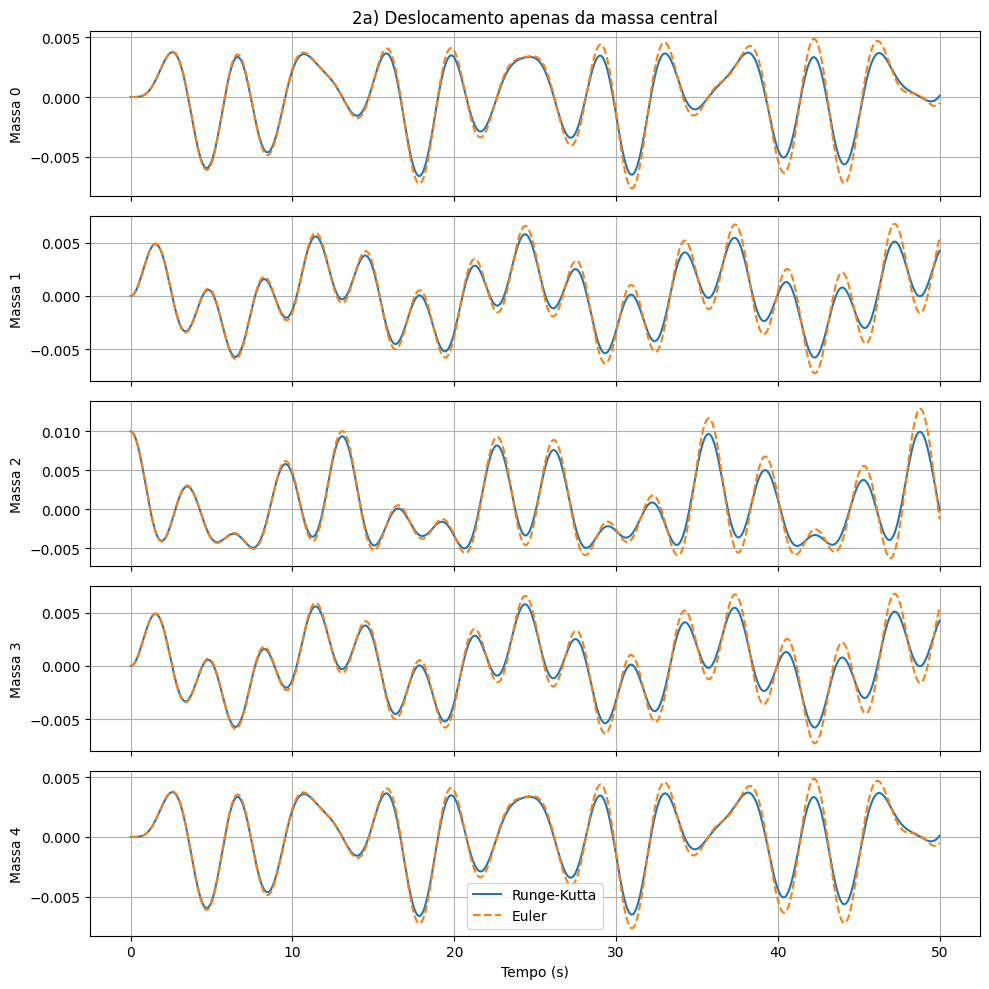

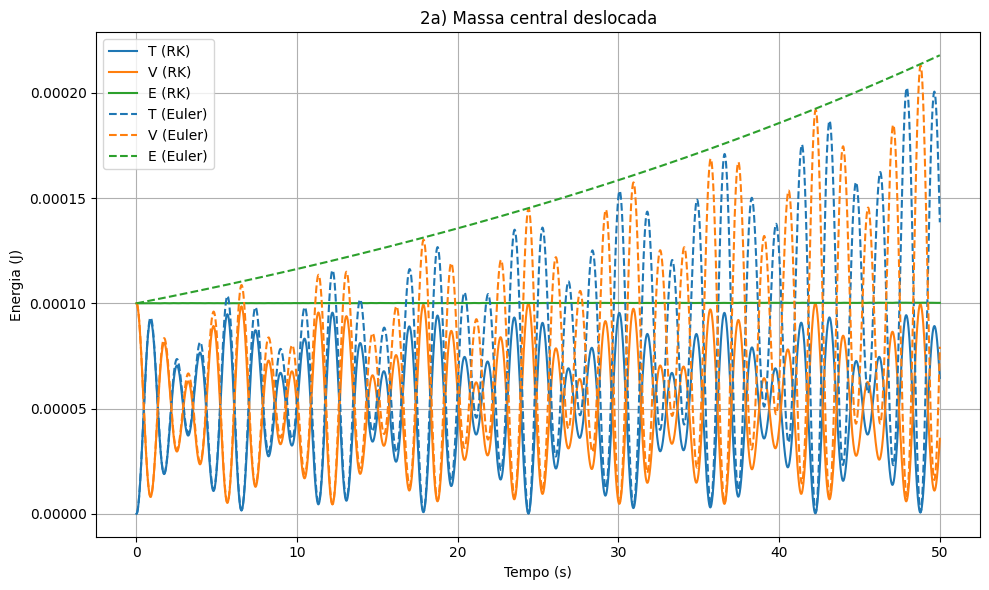

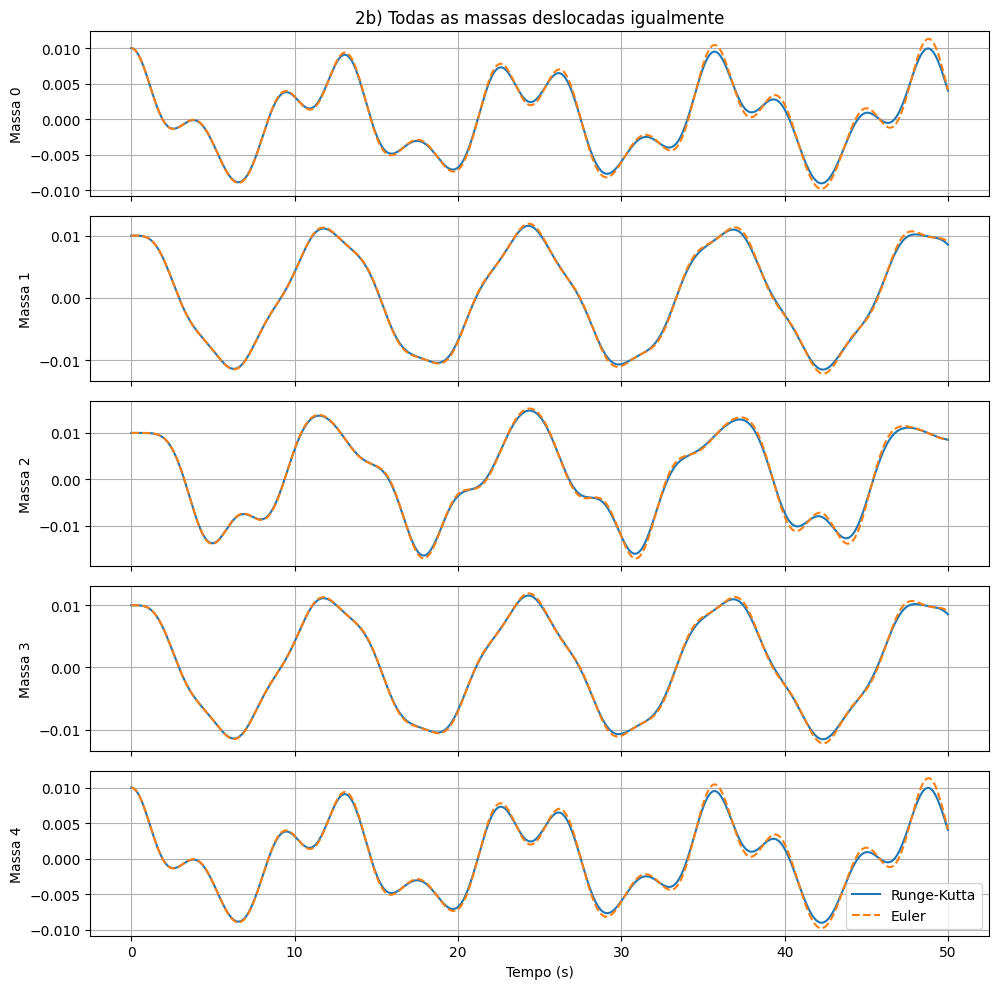

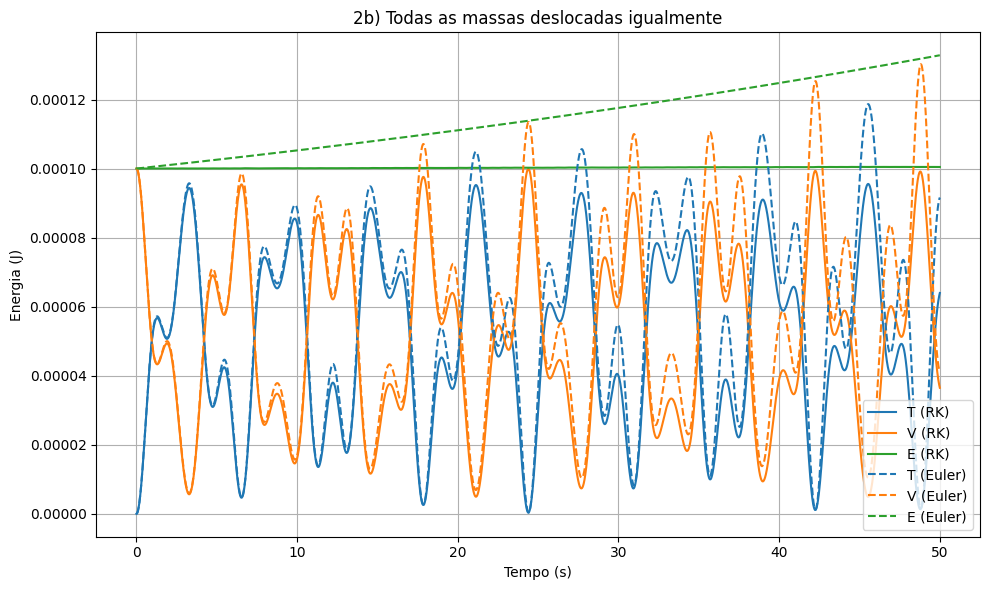

In [ ]:
# Função para desenhar os gráficos de cada massa (posições)

def plot_displacements(t, rk_positions, euler_positions, title_prefix):
    N = rk_positions.shape[0]
    _, axes = plt.subplots(N, 1, figsize=(10, 2 * N), sharex=True)
    for i in range(N):
        ax = axes[i] if N > 1 else axes
        ax.plot(t, rk_positions[i], label='Runge-Kutta')
        ax.plot(t, euler_positions[i], '--', label='Euler')
        ax.set_ylabel(f'Massa {i}')
        ax.grid(True)
        if i == 0: ax.set_title(title_prefix)
    axes[-1].set_xlabel('Tempo (s)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Cálculo das energias cinética, potencial e total e respetivo plot

def plot_energies(t, rk_solution, euler_solution, m_matrix, k_matrix, title):
    
    max_t_index = len(t)
    T_rk, T_euler, V_rk, V_euler = [], [], [], []
    N_masses = len(rk_solution)//2 #pois a solução tem guardadas as posições e as velocidades

    for i in range(max_t_index):
        
        euler_x_vector = np.array([euler_solution[mass][i] for mass in range(N_masses)])
        euler_v_vector = np.array([euler_solution[mass+N_masses][i] for mass in range(N_masses)])
        rk_x_vector = np.array([rk_solution[mass][i] for mass in range(N_masses)])
        rk_v_vector = np.array([rk_solution[mass+N_masses][i] for mass in range(N_masses)])

        RK_T = 0.5 * rk_v_vector.T @ m_matrix @ rk_v_vector
        RK_V = 0.5 * rk_x_vector.T @ k_matrix @ rk_x_vector
        EU_T = 0.5 * euler_v_vector.T @ m_matrix @ euler_v_vector
        EU_V = 0.5 * euler_x_vector.T @ k_matrix @ euler_x_vector

        T_rk.append(RK_T) 
        V_rk.append(RK_V)
        T_euler.append(EU_T)
        V_euler.append(EU_V)

    T_rk = np.array(T_rk)
    V_rk = np.array(V_rk)
    T_euler = np.array(T_euler)
    V_euler = np.array(V_euler)

    E_rk = T_rk + V_rk
    E_euler = T_euler + V_euler

    plt.figure(figsize=(10, 6))
    plt.plot(t, T_rk, label='T (RK)', color='tab:blue')
    plt.plot(t, V_rk, label='V (RK)', color='tab:orange')
    plt.plot(t, E_rk, label='E (RK)', color='tab:green')

    plt.plot(t, T_euler, '--', label='T (Euler)', color='tab:blue')
    plt.plot(t, V_euler, '--', label='V (Euler)', color='tab:orange')
    plt.plot(t, E_euler, '--', label='E (Euler)', color='tab:green')

    plt.title(title)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Energia (J)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



# Parâmetros

N = 5              # Número de massas
m, k = 1.0, 1.0    # Massa [kg] e constante elástica [N/m]
delta_x = 0.01     # Deslocamento [m] a utilizar nas simulações

# Simulação 2a: Apenas a massa central é deslocada
osc_2a = Coupled_Oscillators(N, m, k, k, k)
x0_2a = [delta_x if i == N // 2 else 0 for i in range(N)]
t, rk_2a, _, euler_2a = osc_2a.solve_coupled_system_linear(x0=x0_2a)
plot_displacements(t, rk_2a[:N], euler_2a[:N], "2a) Deslocamento apenas da massa central")
plot_energies(t, rk_2a, euler_2a, osc_2a.M, osc_2a.K, "2a) Massa central deslocada")

# Simulação 2b: Todas as massas deslocadas igualmente no início
osc_2b = Coupled_Oscillators(N, m, k, k, k)
x0_2b = np.full(N, delta_x)
t, rk_2b, _, euler_2b = osc_2b.solve_coupled_system_linear(x0=x0_2b)
plot_displacements(t, rk_2b[:N], euler_2b[:N], "2b) Todas as massas deslocadas igualmente")
plot_energies(t, rk_2b, euler_2b, osc_2b.M, osc_2b.K, "2b) Todas as massas deslocadas igualmente")
